In [ ]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import sklearn
import networkx as nx
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Matplotlib", "Scikit-learn", "Ipywidgets"
]

package_objects = [
    torch, np, pl, pd, mpl, sklearn, ipywidgets
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""

    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.9.0+cu126"""
2,"""NumPy""","""2.0.2"""
3,"""Polars""","""1.31.0"""
4,"""Pandas""","""2.2.2"""
5,"""Matplotlib""","""3.10.0"""
6,"""Scikit-learn""","""1.6.1"""
7,"""Ipywidgets""","""7.7.1"""


### Код xLSTM с практики

In [ ]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0

        block_out_features = out_features // num_blocks

        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        # TODO !!!!
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t) # Всегда <= 1.0
        f = torch.exp(f_tilde + m_prev - m_t) # Всегда <= 1.0

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)

class sLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor
        self.attention_log = []
        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)

        if not self.training:
            score = (q * k)
            self.attention_log.append(score.detach().cpu())

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * (v * k) # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0] # o * (c @ q) / max{|n.T @ q|, 1}

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)

class mLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class xLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type")
            self.layers.append(layer)

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

### Скачиваем датасет и подготавливаем данные

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ag-news-classification-dataset' dataset.
Path to dataset files: /kaggle/input/ag-news-classification-dataset


In [ ]:
train_data = pd.read_csv(path + '/train.csv')
test_data = pd.read_csv(path + '/test.csv')

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
train_data.head()

,Class Index,Title,Description
53541,1,Support independent journalism,Please donate now to our Fall Fund Drive to he...
41728,2,Stingy Falcons Defense Key to 3-0 Start (AP),AP - Maybe the Atlanta Falcons aren't a one-ma...
74819,2,"Pak, Sri Lanka lock horns in Karachi Test today","KARACHI, October 28 (Online): Bruised and batt..."
106459,4,Villages tune in to digital trial,Two villages in Carmarthenshire are the first ...
63062,3,South African gold groups poised for merger,A major re-ordering of South Africa #39;s gold...


In [ ]:
print(train_data.shape, val_data.shape, test_data.shape)

(96000, 3) (24000, 3) (7600, 3)


In [ ]:
from collections import Counter

In [ ]:
lengths = train_data.Description.str.split().str.len()

In [ ]:
print(f"Средняя длина: {lengths.mean():.1f} слов")
print(f"Медиана:        {lengths.median():.0f} слов")
print(f"Минимум:        {lengths.min()} слов")
print(f"Максимум:       {lengths.max()} слов")
print(f"95-й перцентиль: {lengths.quantile(0.95):.0f} слов")
print(f"99-й перцентиль: {lengths.quantile(0.99):.0f} слов")

Средняя длина: 31.1 слов
Медиана:        30 слов
Минимум:        1 слов
Максимум:       173 слов
95-й перцентиль: 45 слов
99-й перцентиль: 63 слов


In [ ]:
counter = Counter()
for desc in train_data.Description:
    counter.update(desc.split())

In [ ]:
len(counter)

138687

In [ ]:
max_vocab_size = 9998

In [ ]:
most_common_words = counter.most_common(max_vocab_size)

### Создаем словарь

In [ ]:
vocab = {'<PAD>': 0, '<UNK>': 1}

for word, _ in most_common_words:
    vocab[word] = len(vocab)

In [ ]:
print(len(vocab))

10000


In [ ]:
def tokenize_and_pad(text, vocab, max_length=40):
    tokens = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    return tokens[:max_length] + [vocab['<PAD>']]*(max_length - len(tokens))

### Создаем датасеты с токенизацией

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class NewsClassification(Dataset):
    def __init__(self, df, vocab, max_length=40):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_length = max_length
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        desc = str(self.df.iloc[idx]['Description'])
        label = int(self.df.iloc[idx]['Class Index']) - 1
        input = torch.tensor(tokenize_and_pad(desc, self.vocab, self.max_length), dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        return input, label



max_length = 40
train_dataset = NewsClassification(train_data, vocab, max_length=max_length)
val_dataset = NewsClassification(val_data, vocab, max_length=max_length)
test_dataset = NewsClassification(test_data, vocab, max_length=max_length)

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

96000 24000 7600


In [ ]:
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

### Класс модели

In [ ]:
class xLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes,
                 head_size=32, num_heads=2, layers=['s', 'm'], batch_first=True,
                 proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.xlstm = xLSTM(
            input_size=embedding_dim,
            head_size=head_size,
            num_heads=num_heads,
            layers = layers,
            batch_first=batch_first,
            proj_factor_slstm=proj_factor_slstm,
            proj_factor_mlstm=proj_factor_mlstm
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Dropout(0.2),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x, i = self.xlstm(x)
        x = x[:, -1, :]
        logits = self.classifier(x)
        return logits


### Начинаем обучение

In [63]:
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup


embedding_dim = 40
head_size = 32
num_heads = 2
layers = ['m', 's']


model = xLSTMClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_classes=4,
    head_size=head_size,
    num_heads=num_heads,
    layers=layers,
    batch_first=True
)


num_epochs = 10
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(0.1 * num_epochs * len(train_loader)),
    num_training_steps = num_epochs * len(train_loader),
    num_cycles=0.5,
)


In [64]:
import wandb

wandb.init(
    project="News Classification",
    config={
        "learning_rate": 1e-3,
        "batch_size": 1024,
        "dataset": "ag-news-classification-dataset",
    }
)

epoch,▁▁▁
train/loss,▂▁█
train/lr,▃▅▆▇█▇▇▆▆▆▅▃▄▇██▇▇▇▇▆▆▅▅▁▄▆███████▇▇▆▆▆▆
val/accuracy,▆█▁
val/loss,▃▁█
epoch,1
train/loss,1.36832
train/lr,0.0006
val/accuracy,0.44171
val/loss,1.24161


In [67]:
def validate(model, criterion, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
      for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)
        loss = criterion(logits, labels)
        val_loss+=loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_val_loss = val_loss/len(val_loader)
    accuracy = correct / total
    return avg_val_loss, accuracy


In [68]:
def train_one_epoch(model, criterion, optimizer, scheduler, train_loader, device):
    model.train()
    train_loss = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        wandb.log({"train/lr": scheduler.get_last_lr()[0],})
        optimizer.step()
        scheduler.step()
        train_loss+=loss.item()

    avg_train_loss = train_loss/len(train_loader)
    return avg_train_loss

In [70]:
def train(model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader, device):
    best_loss = np.inf
    patience_step = 0
    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, criterion, optimizer, scheduler, train_loader, device)
        val_loss, accuracy = validate(model, criterion, val_loader)
        print(f"Epoch: {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        wandb.log({
            "train/loss": train_loss,
            "val/accuracy": accuracy,
            "epoch": epoch,
            "val/loss": val_loss
        })
        if val_loss < best_loss:
            best_loss = val_loss
            patience_step = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_step += 1


In [71]:
train(model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader, device)

100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch: 1/10, Train Loss: 1.3880, Val Loss: 1.2605


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch: 2/10, Train Loss: 1.0951, Val Loss: 0.9284


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Epoch: 3/10, Train Loss: 0.8065, Val Loss: 0.7120


100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch: 4/10, Train Loss: 0.6218, Val Loss: 0.5993


100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch: 5/10, Train Loss: 0.5250, Val Loss: 0.5290


100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


Epoch: 6/10, Train Loss: 0.4680, Val Loss: 0.4933


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Epoch: 7/10, Train Loss: 0.4345, Val Loss: 0.4779


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch: 8/10, Train Loss: 0.4168, Val Loss: 0.4680


100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch: 9/10, Train Loss: 0.4070, Val Loss: 0.4645


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

Epoch: 10/10, Train Loss: 0.4030, Val Loss: 0.4638


### Визуализация весов внимания

['<UNK>', 'representing', 'workers', 'at', 'Turner', '<UNK>', 'say', 'they', 'are', '<UNK>', 'after', 'talks', 'with', '<UNK>', 'parent', 'firm', 'Federal', '<UNK>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


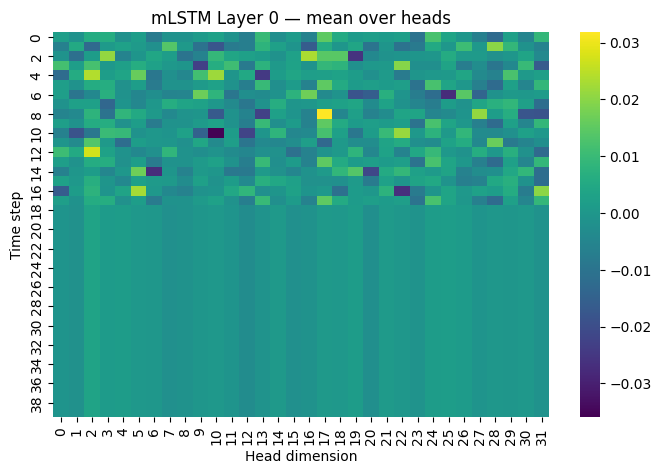

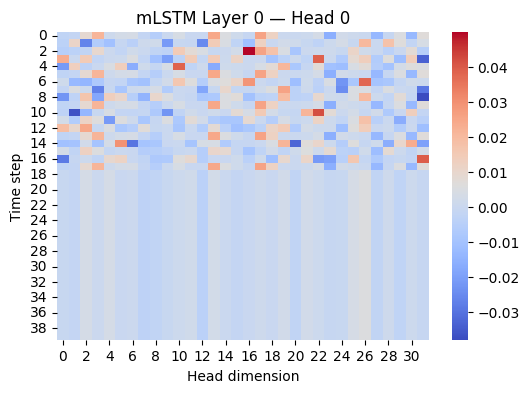

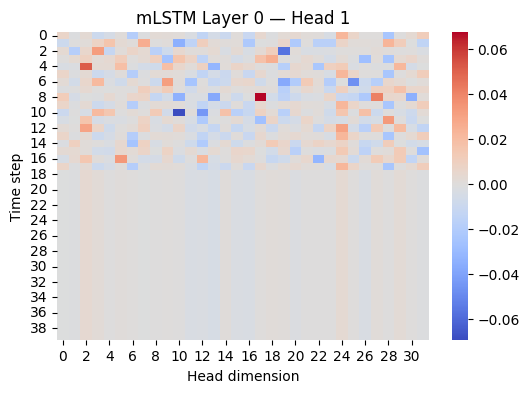

In [80]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


seq_len = 40

for layer in model.xlstm.layers:
    if isinstance(layer, mLSTMBlock):
        layer.attention_log = []

model.eval()

id2word = {idx: word for word, idx in vocab.items()}
input_ids = test_dataset[0][0]
tokens = [id2word.get(int(i), '<UNK>') for i in input_ids]
print(tokens)

input_ids = input_ids.unsqueeze(0)
input_ids = input_ids.to(device)

with torch.no_grad():
    logits = model(input_ids)


all_logs = []

for layer_idx, layer in enumerate(model.xlstm.layers):
    if isinstance(layer, mLSTMBlock):
        if len(layer.attention_log) == 0:
            continue

        log = torch.stack(layer.attention_log)
        log = log.squeeze(1)
        log = log.view(seq_len, num_heads, head_size)
        all_logs.append((layer_idx, log))


for layer in model.xlstm.layers:
    if isinstance(layer, mLSTMBlock):
        layer.attention_log = []



for layer_idx, log_tensor in all_logs:
    log_np = log_tensor.detach().cpu().numpy()

    agg = log_np.mean(axis=1)

    plt.figure(figsize=(8, 5))
    sns.heatmap(agg, cmap="viridis")
    plt.title(f"mLSTM Layer {layer_idx} — mean over heads")
    plt.xlabel("Head dimension")
    plt.ylabel("Time step")
    plt.show()

    for h in range(num_heads):
        plt.figure(figsize=(6, 4))
        sns.heatmap(log_np[:, h, :], cmap="coolwarm")
        plt.title(f"mLSTM Layer {layer_idx} — Head {h}")
        plt.xlabel("Head dimension")
        plt.ylabel("Time step")
        plt.show()


Так как в sLSTM внимания нет вообще, мы модифицировали блок mLSTM и добавили сохранение score = (q * k).

Эти графики показывают, насколько сильно открывается гейт запоминания на каждом токене. Чем ярче цвет, тем сильнее обновляется память на конкретном токене. Тут мы можем видеть, что первый слой (mLSTM) выделяет основные слова (красные блоки). Например, первая голова модели выделяет слово 'workers', оно сильно записывается в память. Так как в нашей модели 'm' слой самый первый (чтобы показать, как модель реагирует на токены), сложных зависимостей мы тут найти не сможем.

### Считаем Accuracy

In [81]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [74]:
val_acc = compute_accuracy(model, val_loader, device)
test_acc = compute_accuracy(model, test_loader, device)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Validation Accuracy: 0.8308
Test Accuracy: 0.8334


### Конец